In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

sent: <object object at 0x12a6cea90>


In [2]:
SYM = 'GDX'  # gold
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_gdx.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Generating derived columns...
(4965, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2006-05-22,31.594475,31.645394,30.440338,30.991949,31.594475,3.452982,1.019441,1.019608,1.013967
2006-05-23,32.213966,33.283241,32.035755,32.035755,32.213966,3.472400,1.005563,0.962066,0.978135
2006-05-24,30.991947,31.883007,30.440337,31.509612,30.991947,3.433727,0.983571,1.049288,1.018072
2006-05-25,32.519482,32.519482,31.382318,31.552045,32.519482,3.481839,1.030662,1.006002,1.010960
2006-05-26,32.714664,32.875906,32.052735,32.875906,32.714664,3.487823,0.995095,0.990143,1.024643
2006-05-30,32.392185,33.707563,32.341270,33.520864,32.392185,3.477917,0.966329,1.017815,1.019125
2006-05-31,32.969246,33.206864,32.349747,33.011680,32.969246,3.495575,0.998715,0.991763,0.957529
2006-06-01,32.697689,32.740123,31.543553,31.569014,32.697689,3.487304,1.035753,1.015573,1.020244
2006-06-02,33.206875,33.427517,32.926826,33.359628,33.206875,3.502757,0.995421,0.974444,1.029134


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2006-05-22     31.645394
2006-05-23     33.283241
2006-05-24     31.883007
2006-05-25     32.519482
2006-05-26     32.875906
                 ...    
2026-02-09    103.089996
2026-02-10    103.800003
2026-02-11    106.470001
2026-02-12    105.790001
2026-02-13    104.139999
Name: high, Length: 4965, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2006-05-22', utc=True)  # first day of legit open/close values
SIM_START

Timestamp('2006-05-22 00:00:00+0000', tz='UTC')

In [7]:
(df.index >= str(SIM_START.date())).sum()

4965

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

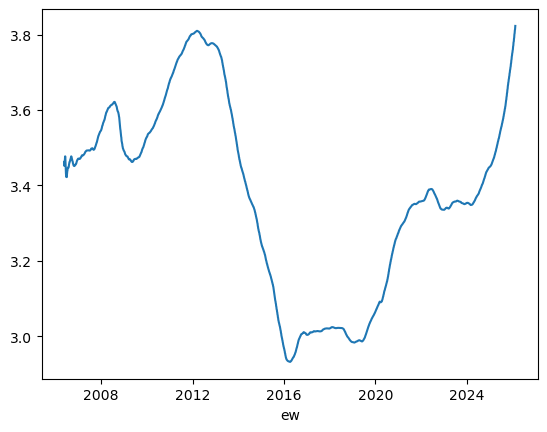

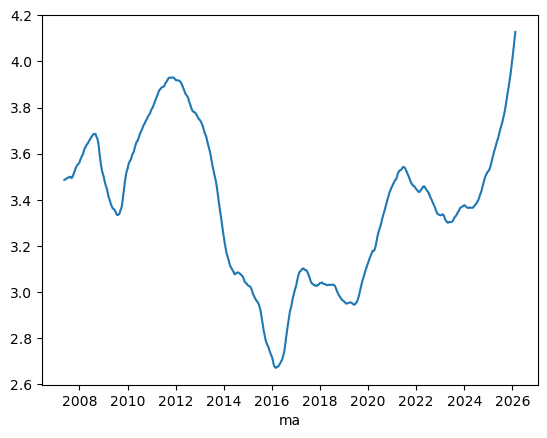

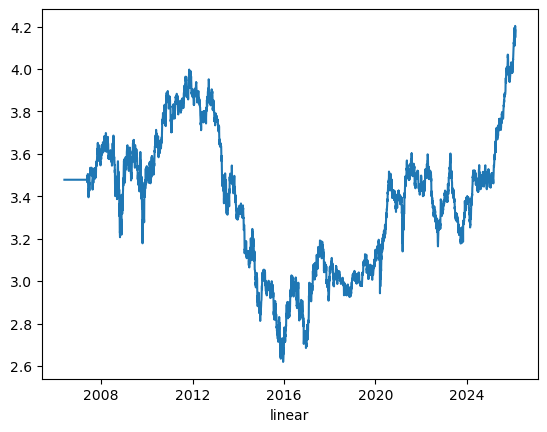

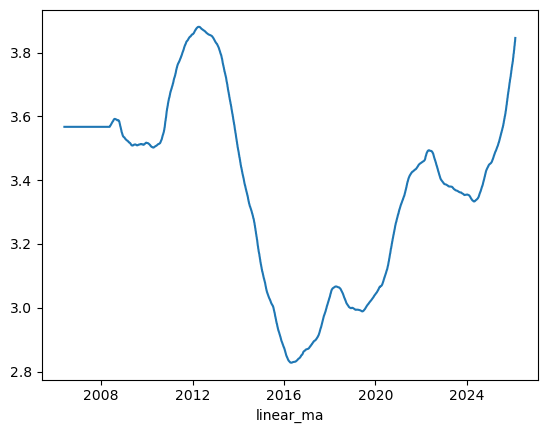

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    ###
    df = df[df.trend_factor.notnull()]
    ###
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= str(SIM_START.date()), :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[str(SIM_START.date()), 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(1059.7907920193973,
 {'time_param': 35,
  'method': 'linear',
  't': 0.9098987833446869,
  'k': 3.46902876874218,
  'as_q': True,
  'transform_f': 'bounded_curve'})

Do nothing res: 3.2898158024182167
Round 1: 1150.6820272017662
New best: 1150.6820272017662
{'time_param': 35, 'method': 'linear', 't': 0.9098987833446869, 'k': 3.46902876874218, 'as_q': True, 'transform_f': 'bounded_curve'}


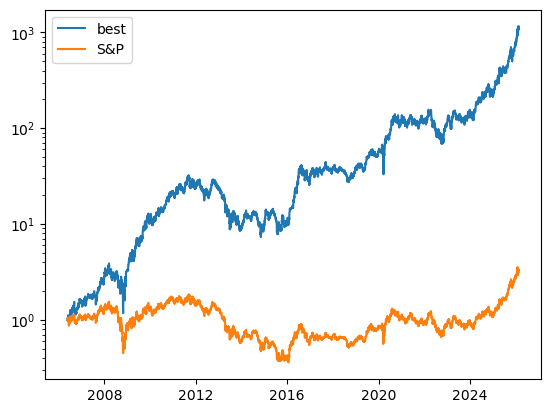

Round 2: 756.7822790251204
Round 3: 1.8849391370308215
Round 4: 658.1141454804765
Round 5: 52.38495489733579
Round 6: 2.2045364705829025
Round 7: 31.472172742132294
Round 8: 1.180027969728806
Round 9: 51.08279695903738
Round 10: 96.95984665154593
Round 11: 27.43634805000177
Round 12: 134.75989613598148
Round 13: 808.4860509684348
Round 14: 133.8111736841348
Round 15: 1.1756328042163902
Round 16: 771.1677201758423
Round 17: 47.33736225847569
Round 18: 148.04813809676125
Round 19: 2.2113793932248216
Round 20: 3.135498344771128
Round 21: 11.762661510606481
Round 22: 593.2996039551949
Round 23: 37.8032316559205
Round 24: 7.66328842931172
Round 25: 1.5962388559563165
Round 26: 3.0607281673526807
Round 27: 142.31007904335652
Round 28: 65.6936697829081
Round 29: 856.214025190814
Round 30: 146.5771451974793
Round 31: 1.3693991140204784
Round 32: 128.82443788248196
Round 33: 575.225859385565
Round 34: 291.7861575552372
Round 35: 593.1256209717519
Round 36: 25.17996040275781
Round 37: 65.6801857

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 3.2898158024182167
Round 1: 748.2526903649139
Round 2: 1037.4607731487183
Round 3: 528.7197199428097
Round 4: 800.4293278621492
Round 5: 840.4517100353612
Round 6: 850.2593622464823
Round 7: 1051.9440661362537
Round 8: 906.1202001438006
Round 9: 307.52552826823865
Round 10: 1060.2147500083934

Factor: 1.03125
Do nothing res: 3.2898158024182167
Round 1: 752.8443453128722
Round 2: 690.299298008266
Round 3: 756.9767954055085
Round 4: 524.6074546446764
Round 5: 354.63516479078845
Round 6: 627.5242641975616
Round 7: 770.1699950824285
Round 8: 960.8953306190565
Round 9: 250.43945067526437
Round 10: 310.9929384605822

Factor: 1.015625
Do nothing res: 3.2898158024182167
Round 1: 564.7484764861265
Round 2: 691.0390022624658
Round 3: 480.1497929139696
Round 4: 770.9305786473532
Round 5: 771.3922042454807
Round 6: 218.83015288975952
Round 7: 577.0956203690673
Round 8: 770.8771422149274
Round 9: 769.7200944394384
Round 10: 769.7706763765722

Factor: 1.0078125
Do noth

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9958811752380708

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.8060032232070911

In [24]:
params_out

{'time_param': 35,
 'method': 'linear',
 't': 0.9098987833446869,
 'k': 3.46902876874218,
 'as_q': True,
 'transform_f': 'bounded_curve'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


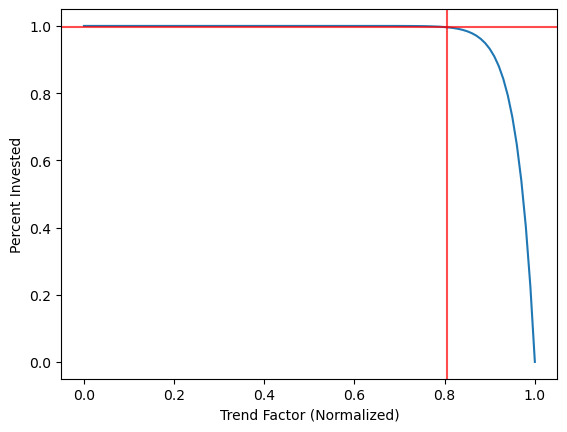

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

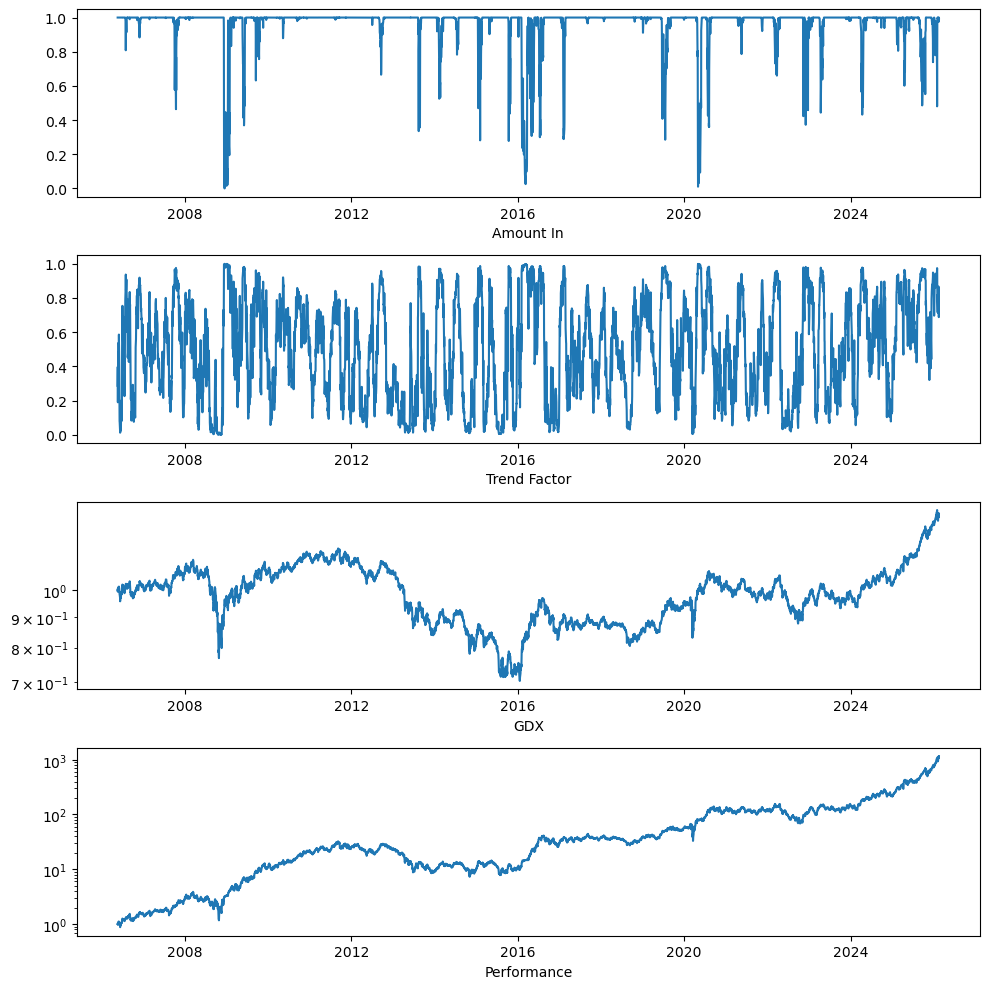

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

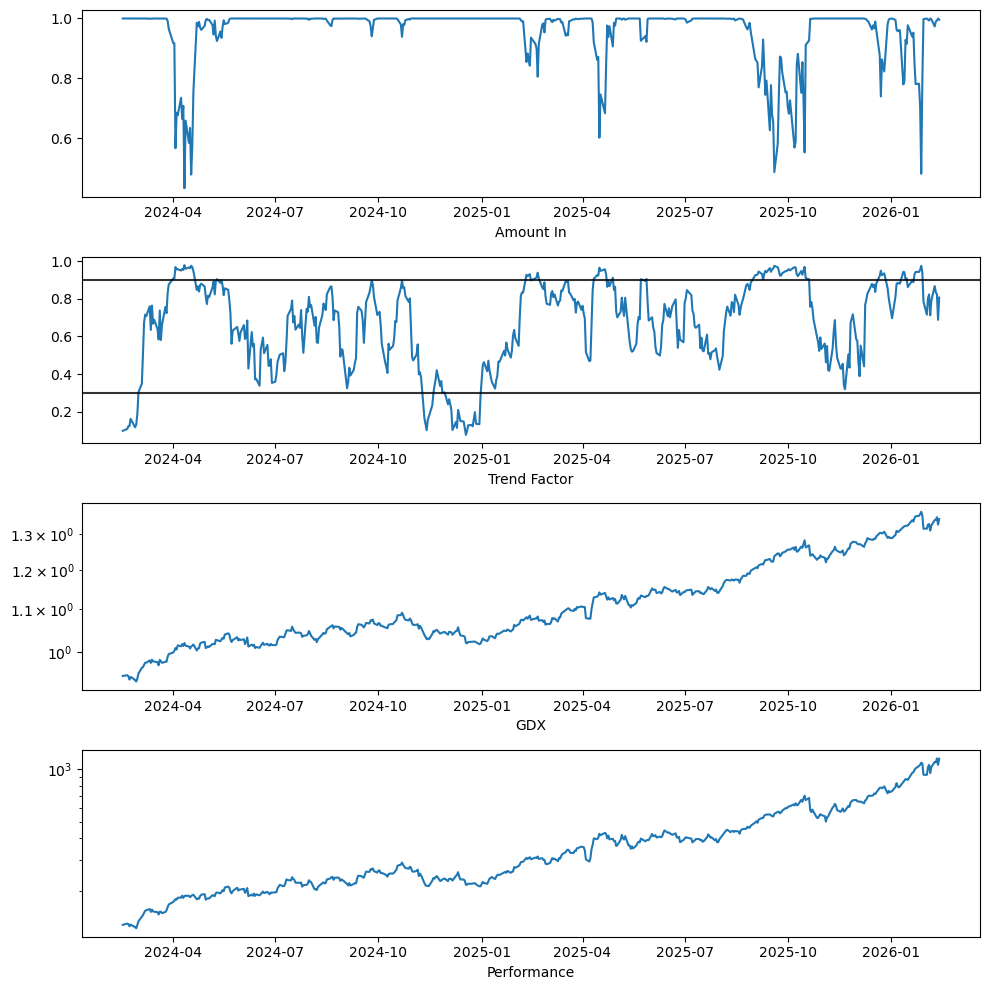

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')
plt.axhline(y=0.3, color='k', alpha=0.8)
plt.axhline(y=0.9, color='k', alpha=0.8)

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('GDX')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.9959

In [30]:
# n days
n = (df.index >= str(SIM_START.date())).sum()
# n years
t = n / 250
# amt at start
p = df.loc[str(SIM_START.date()), 'value']
amt = df.iloc[-1].value
p, t, amt

(31.59447479248047, 19.86, 103.94000244140625)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.42602340338892253

In [32]:
stop

NameError: name 'stop' is not defined

In [33]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(1150.6820272017662,
 {'time_param': 35,
  'method': 'linear',
  't': 0.9098987833446869,
  'k': 3.46902876874218,
  'as_q': True,
  'transform_f': 'bounded_curve'})

In [34]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['gdx'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1255061814347231, 1.0], 'dia': [1.1652110627725774, 1.0], 'nas': [1.2443723483760059, 1.0], 'rus': [1.3087489595360287, 1.0], 'jpxn': [1.067609313829114, 1.0], 'ktec': [1.6317632641049638, 0.0], 'eem': [1.210138091847281, 1.0], 'nfty': [1.262556097182899, 1.0], 'gdx': [1.4260234033889225, 0.9959]}


In [35]:
# Normalized returns
keys = ['sp', 'nas', 'dia', 'rus', 'jpxn', 'ktec', 'eem', 'gdx', 'nfty']
rs = np.array([j[k][0] - 1 for k in keys])

# Manually reduce KTEC & GDX
#idx_ktec = keys.index('ktec')
#rs[idx_ktec] /= 1
#idx_gdx = keys.index('gdx')
#rs[idx_gdx] /= 1
#

rs = rs / rs.sum()
for k, r in zip(keys, rs):
    print(f'{k:4s}: {r:.4f}')

sp  : 0.0514
nas : 0.1001
dia : 0.0677
rus : 0.1264
jpxn: 0.0277
ktec: 0.2587
eem : 0.0861
gdx : 0.1745
nfty: 0.1075


In [36]:
# Fraction In
fracs_in = np.array([j[k][1]  for k in keys])
for k, f in zip(keys, fracs_in):
    print(f'{k:4s}: {f:.4f}')

sp  : 1.0000
nas : 1.0000
dia : 1.0000
rus : 1.0000
jpxn: 1.0000
ktec: 0.0000
eem : 1.0000
gdx : 0.9959
nfty: 1.0000


In [ ]:
stop

In [ ]:
cash = 3634       # Don't Forget Me!!!
#                   SPY,   ONEQ,  DIA,   IWF,   JPXN,  KTEC, EEM,   GDX,   NFTY
current = np.array([13589, 28413, 25278, 34225, 8073,  0,    22995, 40461, 30482])

val = current.sum() + cash
target = (val * rs * fracs_in).round()
for k, t in zip(keys, target):
    print(f'{k:4s}: {t:7.0f}')

In [ ]:
# normalize
target /= target.sum()
target *= val
for k, t in zip(keys, target):
    print(f'{k:4s}: {t:7.0f}')

In [ ]:
for k, diff in zip(keys, target - current):
    print(f'{k:4s}: {diff:7.0f}')

In [ ]:
# TEST
from datetime import datetime

In [ ]:
def get_adjusted_date():
    'Treat weekend dates as preceding Friday'
    now = datetime.now()
    weekday = now.weekday()
    if weekday == 5:    # Sat                                                   
        return now - timedelta(1)
    elif weekday == 6:  # Sun                                                   
        return now - timedelta(2)
    return now

In [ ]:
NOW = get_adjusted_date()
TODAY = NOW.date()

In [ ]:
print('Uploading Schwab data...')
path_start = f'PCRA_Custodial-Positions-{str(TODAY)}'
print(f'Looking for Schwab file: {path_start}...')
filename = [
    f for f in os.listdir(DOWNLOADS) if f.startswith(path_start)
][0]
path = f'{DOWNLOADS}/{filename}'

In [ ]:
has_quotes = False
with open(path, 'r') as f:
    for line in f:
        if line.startswith('"Symbol'):
            has_quotes = True
            break
has_quotes

In [ ]:
data = []
inds = []
is_header = True

with open(path, 'r') as f:
    for line in f:
        cash = '"Cash' if has_quotes else 'Cash'
        acct = '"Account' if has_quotes else 'Account'
        if line.startswith(cash) or line.startswith(acct):
            continue
        if not is_header:
            col_split = ',"' if has_quotes else ','
            cols = line.split(col_split)
            symbol = cols[0].strip('""')
            dollar = '"$' if has_quotes else '$'
            try:
                amt = float(cols[6].strip(dollar))
            except ValueError:
                amt = 0
            except:
                raise
            inds.append(symbol)
            data.append(amt)
        sym = '"Symbol"' if has_quotes else 'Symbol'
        if line.startswith(sym):
            is_header = False

In [ ]:
inds